# MLP Language Model

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/fitter-happier-models/blob/master/docs/notebooks/language-modeling/02-mlp.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/fitter-happier-models?style=social)](https://github.com/particle1331/fitter-happier-models)

---

## Introduction

In this notebook, we implement a **multilayer perceptron** (MLP) character-level language model. We will improve our previous bigram character-level language model for maximizing the likelihood of next characters by passing embeddings of characters in its context to an MLP network. Instead of learning a large lookup table for each character sequence as in the previous notebook, here the embedding vectors are combined to make a prediction, allowing for better generalization with less parameters to learn.

**References:** {cite}`makemore2` {cite}`Bengio2003` [[`makemore`](https://github.com/karpathy/makemore)]

## Preliminaries

In [1]:
import torch

import os
import math
import warnings
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from matplotlib_inline import backend_inline

DATASET_DIR = Path("./data").absolute()
TRAIN_RATIO = 1.0
RANDOM_SEED = 9000
torch.manual_seed(RANDOM_SEED)

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')

Same **names dataset** as previous notebook:

In [2]:
names = open(DATASET_DIR / 'names.txt', 'r').read().splitlines()
names = names[:int(TRAIN_RATIO * len(names))]

print(len(names))
names[:10]

32033


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

```{figure} ../../img/char-dataset.drawio.svg
---
width: 330px
name: char-dataset.drawio
---

Using a **block size** of 3 to sample training examples for the name `'olivia'`. Each row indicates an input-output pair in the training dataset, where the input block is represented by the orange cubes, and the blue block highlights the target character.
```

We define a helper class for sampling input-output pairs from the names dataset. The parameter `block_size` refers to the fixed number of previous characters that the model will use for predicting the next one.

In [3]:
class CharDataset:
    def __init__(self, names: list[str], block_size: int):
        self.names = names
        self.chars = ['.'] + sorted(list(set(''.join(names))))
        self.block_size = block_size
        self.itos = dict(enumerate(self.chars))
        self.stoi = {c: i for i, c in self.itos.items()}

    def decode(self, x):
        return ''.join(self.itos[i] for i in x)

    def encode(self, word):
        return [self.stoi[c] for c in word]

    def build_dataset(self):
        """Creating subsequences -> next character target."""
        xs = []
        ys = []
        for name in self.names:
            context = ['.'] * self.block_size
            for c in name + '.':
                xs.append(self.encode(''.join(context)))
                ys.append(self.stoi[c])
                context = context[1:] + [c]
        
        return torch.tensor(xs), torch.tensor(ys)

Note that we simply encode each character in a block to its corresponding integer.

In [4]:
import pandas as pd

dataset = CharDataset(names, block_size=3)
itos = dataset.itos
stoi = dataset.stoi

xs, ys = dataset.build_dataset()

df = pd.DataFrame({'xs': list(xs.numpy()), 'ys': list(ys.numpy())})
df['seq'] = df['xs'].apply(lambda x: ''.join(itos[c] for c in x))
df['target'] = df['ys'].map(itos)
df.head(12)

,xs,ys,seq,target
0,"[0, 0, 0]",5,...,e
1,"[0, 0, 5]",13,..e,m
2,"[0, 5, 13]",13,.em,m
3,"[5, 13, 13]",1,emm,a
4,"[13, 13, 1]",0,mma,.
5,"[0, 0, 0]",15,...,o
6,"[0, 0, 15]",12,..o,l
7,"[0, 15, 12]",9,.ol,i
8,"[15, 12, 9]",22,oli,v
9,"[12, 9, 22]",9,liv,i


In the experiments, we will stick with `block_size=3` for all our models. Using a larger block size does not make sense since most names have around 6 to 7 characters:

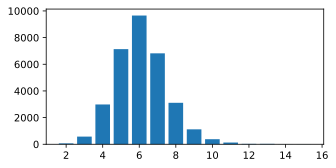

In [5]:
from collections import Counter

count = Counter([len(n) for n in names])
plt.figure(figsize=(5, 2.5))
plt.bar(count.keys(), count.values());

## Character embeddings

Recall that the names we generated using bigrams were pretty bad. Trigrams improve this a bit. But it required a significantly larger matrix. Indeed, the number of rows of the count matrix grows exponentially with context size. There is not enough data to train such a model.

Instead, our models will learn an **embedding** for each character, i.e. learnable vector representations of characters, along with the parameters of the MLP network for combining the embedding vectors to calculate probabilities. This model architecture is based on  {cite}`bengio2003a`.

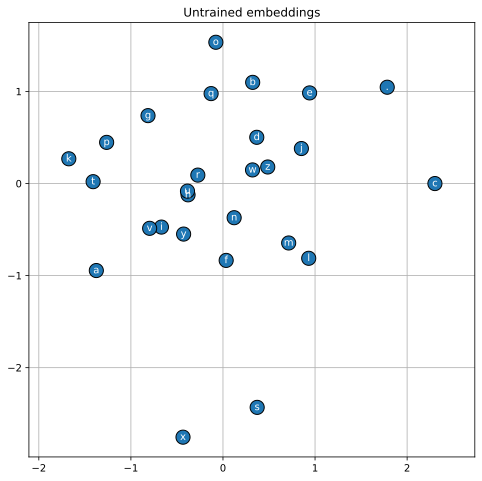

In [6]:
import torch
import string

C = torch.randn(27, 2)
chars = '.' + string.ascii_lowercase

plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200, zorder=3, edgecolors='black')
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), chars[i], ha="center", va="center", color='white')

plt.grid('minor')
plt.axis('equal')
plt.title("Untrained embeddings");

Initially, the vector representation of the characters are randomly distributed in the *m*-dimensional space. This embedding will be tuned by the network so that similar characters moves closer to each other in the embedding space. 

Unlike in our previous model for *n*-grams which essentially learns a lookup table, this can easily represent character sequences that are out-of-distribution, i.e. those that appear very rarely in the training data. The embedding allows transfer of knowledge for different contexts by means of character similarity. This allows the model to generalize better. 

## Network architecture

We will implement the neural network shown in the following figure. 
The first component of the network is an embedding matrix, where each row corresponds to an embedding vector. Then, the embedding vectors are concatenated in the correct order and passed to the 2-layer MLP. Here the first layer applies tanh nonlinearity, while the second layer simply performs a linear operation to get the logits. 

Note that during training the weights of the MLP adjusts for character ordering in the input block. And parameters are modified such that the predict probability of the next character is maximized. These include the parameters of the layers as well as the embedding table. To get the unnormalized distribution, we simply apply `.exp()` on the logits. Note that the input and output layer of the network has the same width.

```{figure} ../../img/mlp-char-level.drawio.svg
---
width: 600px
name: mlp-char-level.drawio
---

Schematic diagram of our MLP neural net with embedding and block size of 3. Shown here is the input string `"ner"` passed to the embedding layer. The resulting concatenation of embeddings are passed to the two-layer MLP with logits. Note that the embeddings are concatenated in the correct order.
```

Note that the construction of the embedding vector can be expressed as a matrix multiplication with inputs as concatenated one hot vectors. The matrix is a block matrix consisting of the embedding matrix with **shared weights**. Weight sharing is important since we want to have the same embedding for all slots in the input block. Expressing this operation as matrix multiplication allows us to easily write an explicit backward method for this operation.

```{figure} ../../img/embedding.drawio.svg
---
width: 500px
name: embedding.drawio
---
Construction of the word embedding using matrix multiplication. The matrix consists of blocks of shared weights of the embedding matrix. Observe that the length of the embedding vector is equal to the product of the block size and the embedding size.
```

In [7]:
class MLP:
    def __init__(self, embedding_size, width, block_size):
        self.width = width
        self.blk_size = block_size
        self.emb_size = embedding_size
        
        self.C  = torch.randn(27, self.emb_size)
        self.W1 = torch.randn((self.blk_size * self.emb_size, self.width))
        self.b1 = torch.randn(self.width)
        self.W2 = torch.randn((self.width, 27))
        self.b2 = torch.randn(27)
        
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad = True

    def __call__(self, xs: list[int]):
        x = self.C[xs].view(-1, self.blk_size * self.emb_size)
        h = torch.tanh(x @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        return logits

    def zero_grad(self):
        for p in self.parameters:
           p.grad = None        

**Remark.** Using `.view` so that the same underlying storage of the tensor is used in the computation.

### Model training

Optimizing `F.cross_entropy` loss which expects logits (unnormalized scores). This is equivalent to maximizing next character likelihood.

In [8]:
import torch.nn.functional as F

def optim_step(model, lr):
    for p in model.parameters:
        p.data -= lr * p.grad

def train_model(model, xs, ys, num_steps=100, lr=0.1):
    losses = []
    for k in range(num_steps):
        logits = model(xs)
        loss = F.cross_entropy(logits, target=ys)

        model.zero_grad()
        loss.backward()
        optim_step(model, lr=lr)

        # logging
        losses.append(loss.item())
        if (k % (num_steps // 10) == 0) or (k == num_steps - 1):
            print(f"[{k+1:>03d}/{num_steps}]   loss={loss:.4f}")
    
    return losses


model = MLP(embedding_size=2, width=100, block_size=3)
hist = train_model(model, xs, ys, num_steps=100, lr=0.1)

[001/100]   loss=13.8372
[011/100]   loss=7.2653
[021/100]   loss=5.1503
[031/100]   loss=4.4114
[041/100]   loss=4.0415
[051/100]   loss=3.8243
[061/100]   loss=3.6682
[071/100]   loss=3.5444
[081/100]   loss=3.4421
[091/100]   loss=3.3558
[100/100]   loss=3.2889


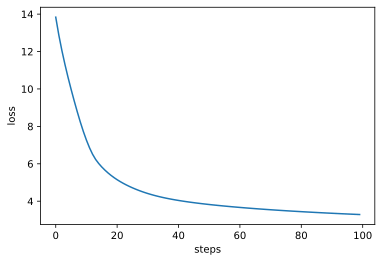

In [9]:
plt.plot(hist)
plt.ylabel('loss')
plt.xlabel('steps');

### Using mini-batches

It is crucial to use **mini-batches** to approximate the gradient. This leads to noisier and more updates, but drastically reduces the resources needed for training. Updating training function:

In [10]:
def train_step(model, x, y, lr=0.1):
    """One step of backward pass and weight update."""
    loss = F.cross_entropy(model(x), y)

    model.zero_grad()
    loss.backward()
    optim_step(model, lr=lr)

    return loss.item()


def train_model(
        model, 
        xs_trn, ys_trn, 
        batch_size, 
        num_steps, 
        lr=0.1, 
        verbose=True
    ):

    losses = []
    for k in range(num_steps):
        
        B = torch.randint(0, xs_trn.shape[0], (batch_size,))
        x, y = xs_trn[B], ys_trn[B]
        loss = train_step(model, x, y, lr)

        # logging
        losses.append(loss)
        if verbose and ((k % (num_steps // batch_size) == 0) or (k == num_steps - 1)):
            print(f"[{k+1:>0{int(len(str(num_steps)))}d}/{num_steps}]   loss: {loss:.4f}")

    return losses


model = MLP(embedding_size=2, width=100, block_size=3)
hist = train_model(model, xs, ys, batch_size=32, num_steps=10000, lr=0.1)

[00001/10000]   loss: 11.5332
[00313/10000]   loss: 2.5991
[00625/10000]   loss: 2.8526
[00937/10000]   loss: 2.3629
[01249/10000]   loss: 2.6773
[01561/10000]   loss: 2.7506
[01873/10000]   loss: 2.5165
[02185/10000]   loss: 2.7478
[02497/10000]   loss: 2.6467
[02809/10000]   loss: 2.6493
[03121/10000]   loss: 3.0720
[03433/10000]   loss: 2.5187
[03745/10000]   loss: 2.6947
[04057/10000]   loss: 2.7197
[04369/10000]   loss: 2.4404
[04681/10000]   loss: 2.6555
[04993/10000]   loss: 2.6124
[05305/10000]   loss: 2.2073
[05617/10000]   loss: 2.2630
[05929/10000]   loss: 2.6753
[06241/10000]   loss: 2.1704
[06553/10000]   loss: 2.6563
[06865/10000]   loss: 2.4812
[07177/10000]   loss: 3.0072
[07489/10000]   loss: 2.6320
[07801/10000]   loss: 2.0277
[08113/10000]   loss: 2.6169
[08425/10000]   loss: 2.5608
[08737/10000]   loss: 2.9868
[09049/10000]   loss: 2.3885
[09361/10000]   loss: 2.5172
[09673/10000]   loss: 2.4534
[09985/10000]   loss: 2.4768
[10000/10000]   loss: 2.4622


Noisier updates:

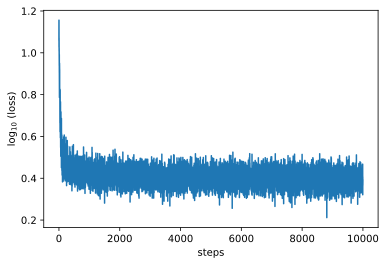

In [11]:
plt.plot(torch.tensor(hist).log10(), )
plt.xlabel("steps")
plt.ylabel("$\log_{10}$ (loss)");

## Tuning the hyperparameters

To clean up our experimentation code, let us create a trainer class that collects all objects that will be used during training, and also make the training code more readable. For example, this allows us to simply call `trainer.run(n)` to run training with `n` steps. Note that also implement an additional new method `lr_finder` which we will discuss shortly.

In [12]:
class Engine:
    def __init__(self,
            x_train, y_train,
            x_valid, y_valid,
            batch_size=32
        ):
        
        self.x_train = x_train
        self.y_train = y_train
        self.x_valid = x_valid
        self.y_valid = y_valid
        self.batch_size = batch_size


    def run(self, model, num_steps, *, lr=0.1, verbose=True, lr_find=False, **kwargs):
        """Run training with given no. of optim steps."""

        if lr_find:
            lr0 = self.lr_finder(model, **kwargs)
            print(f"Setting learning rate to {lr0:.2e}")
            lr = lr0

        self._lr_counter = 0
        self._best_valid_loss = float("inf")
        loss_train = {}
        loss_valid = {}

        for k in range(num_steps):
            x, y = self.sample_batch()
            loss = self.train_step(model, x, y, lr=lr)
            loss_train[k] = loss
            
            if (k % (num_steps // self.batch_size) == 0) or (k == num_steps - 1):
                loss_val = self.evaluate(model)
                loss_valid[k] = loss_val
                lr = self.lr_step(lr, loss_val, verbose)
                if verbose:
                    print(f"[{k+1:>0{int(len(str(num_steps)))}d}/{num_steps}]      loss={loss:<8.4f}    loss_val={loss_val:.4f}")

        return {
            "loss_train": loss_train,
            "loss_valid": loss_valid
        }


    def lr_finder(self, model, lre_min=-3, lre_max=0, plot=False, color='C0'):
        """Finding a good base learning rate for training."""

        # Training loss at each step
        num_steps = 1000
        lre = torch.linspace(lre_min, lre_max, num_steps)
        lrs = 10 ** lre
        
        losses = []
        for k in range(num_steps):
            x, y = self.sample_batch()
            loss = self.train_step(model, x, y, lr=lrs[k])
            losses.append(loss)

        # Moving average of previous losses
        w = num_steps // 20    # i.e. 1/2 (num_steps // 10)
        loss_ma = []
        for i in range(w, num_steps - w):
            loss_ma.append((lre[i].item(), sum(losses[i-w: i+w]) / (2 * w)))

        # Minimum of MA curve as best learning rate
        i_min = np.argmin([y for _, y in loss_ma])
        assert w < i_min < (num_steps - w) - 1

        # Shift to left (min may be too aggressive)
        best_lre = lre[i_min - w]
        best_lr = 10 ** best_lre

        # Plotting
        if plot:
            plt.figure(figsize=(5, 2.5))
            plt.plot(lre, torch.tensor(losses).numpy(), alpha=0.2, color=color)
            plt.ylabel('loss')
            plt.xlabel('learning rate exponent')
            plt.plot([l[0] for l in loss_ma], [l[1] for l in loss_ma], color=color)
            plt.title(f'$\lambda$ = 10^({best_lre:.1f}) = {best_lr:.1e}')
            plt.axvline(best_lre, linestyle='dashed', linewidth=1.2, color='black', zorder=-1)
            
        return best_lr


    def train_step(self, model, x, y, lr):
        """One step of backward pass and weight update."""
        loss = F.cross_entropy(model(x), target=y)
        
        model.zero_grad()        
        loss.backward()
        optim_step(model, lr=lr)
        
        return loss.item()


    @torch.no_grad()
    def evaluate(self, model):
        loss = F.cross_entropy(model(self.x_valid), self.y_valid)
        return loss.item()


    def sample_batch(self):
        B = torch.randint(0, self.x_train.shape[0], (self.batch_size,))     
        x = self.x_train[B]
        y = self.y_train[B]
        return x, y


    def lr_step(self, lr, loss_valid, verbose):
        if loss_valid < self._best_valid_loss:
            self._best_valid_loss = loss_valid
            self._lr_counter = 0
        else:
            self._lr_counter += 1
            if self._lr_counter == 3:
                lr *= 0.1
                self._lr_counter = 0
                if verbose:
                    print(f"Decreasing learning rate to {lr:.2e}")
        return lr

To tune our network, we need to have a validation set:

In [13]:
from sklearn.model_selection import StratifiedKFold

def create_folds(x, y, seed=RANDOM_SEED):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    folds = torch.zeros(x.shape[0])
    for fold, (train_, valid_) in enumerate(kf.split(x, y)):
        folds[valid_] = fold

    x_train, y_train = x[folds >  1], y[folds >  1]
    x_valid, y_valid = x[folds == 1], y[folds == 1]
    x_test,  y_test  = x[folds == 0], y[folds == 0]

    return x_train, y_train, x_valid, y_valid, x_test, y_test


x_train, y_train, \
x_valid, y_valid, \
x_test,  y_test = create_folds(xs, ys)

### Finding a good base learning rate

Observe that `lr_finder()` performs training on the model with exponentially increasing learning rate at each optimization step while recording the loss. The returned base learning rate is chosen large enough just before the loss starts destabilizing. On the other hand, during training we work backwards by decreasing the learning rate via a **schedule**. This is a heuristic that works well in practice but is very cheap to compute.

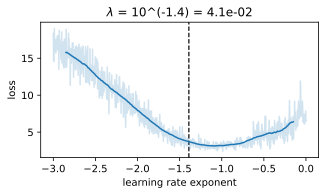

In [14]:
trainer = Engine(
    x_train, y_train,
    x_valid, y_valid,
    batch_size=32
)

model = MLP(embedding_size=2, width=100, block_size=3)
lr0 = trainer.lr_finder(model, lre_min=-3, lre_max=0, plot=True)

Note that we choose a large enough range and number of steps such that we can see a well-defined U-shape in the curve. The `assert` statement allows us to make sure this is satisfied without having to visualize the plot. Also, observe that the minibatches from the training dataset is used as input, since we want to mimic how the learning rate affects training.

### Increasing network width

Training with different network widths:

In [15]:
from tqdm.auto import tqdm

results = {}
for i, h in tqdm(enumerate(range(100, 1000, 100))):
    model = MLP(embedding_size=2, width=h, block_size=3)
    results[h] = trainer.run(model, 200000, verbose=False, lr_find=True)

0it [00:00, ?it/s]

Setting learning rate to 9.01e-02
Setting learning rate to 4.04e-02
Setting learning rate to 2.28e-02
Setting learning rate to 2.37e-02
Setting learning rate to 1.26e-02
Setting learning rate to 1.70e-02
Setting learning rate to 1.41e-02
Setting learning rate to 1.12e-02
Setting learning rate to 1.34e-02


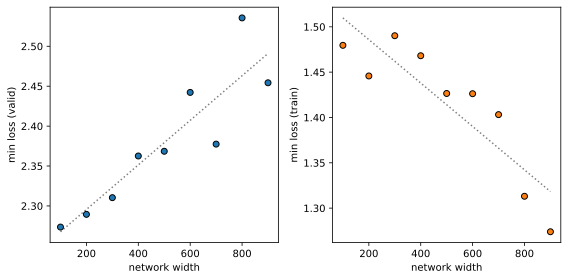

In [16]:
from sklearn.linear_model import LinearRegression
import numpy as np

x_ax = list([x] for x in results.keys())
y_ax_valid = [min(results[x]['loss_valid'].values()) for x in results.keys()]
y_ax_train = [min(results[x]['loss_train'].values()) for x in results.keys()]

xx = np.linspace(100, 900, 100)
train_trend = LinearRegression()
valid_trend = LinearRegression()
train_trend.fit(x_ax, y_ax_train)
valid_trend.fit(x_ax, y_ax_valid)
yy_train = train_trend.predict(xx.reshape(-1, 1))
yy_valid = valid_trend.predict(xx.reshape(-1, 1))

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(xx, yy_valid, color='grey', linestyle='dotted')
ax[1].plot(xx, yy_train, color='grey', linestyle='dotted')
ax[0].scatter(x_ax, y_ax_valid, edgecolor='black', color='C0', zorder=3)
ax[1].scatter(x_ax, y_ax_train, edgecolor='black', color='C1', zorder=3)
ax[0].set_xlabel('network width')
ax[1].set_xlabel('network width')
ax[0].set_ylabel('min loss (valid)')
ax[1].set_ylabel('min loss (train)')
fig.tight_layout()

It looks like increasing the network width only results in the network overfitfing the training dataset. Our guess is that embedding size acts like a **bottleneck** to network capacity. We investigate this in a later section.

### Trained character embeddings

In this section we will look at embeddings of chacters in two-dimensional space. Recall from the network structure that, vectors with similar embeddings have similar roles in predicting the next character. 

In [17]:
model = MLP(embedding_size=2, width=100, block_size=3)
trainer.run(model, 200000, verbose=True, lr_find=True);

Setting learning rate to 7.48e-02
[000001/200000]      loss=8.4545      loss_val=6.4021
[006251/200000]      loss=2.4891      loss_val=2.4449
[012501/200000]      loss=2.2123      loss_val=2.4229
[018751/200000]      loss=2.3503      loss_val=2.4218
[025001/200000]      loss=2.2351      loss_val=2.3879
[031251/200000]      loss=2.6620      loss_val=2.3798
[037501/200000]      loss=2.5163      loss_val=2.3616
[043751/200000]      loss=2.3313      loss_val=2.3483
[050001/200000]      loss=2.5714      loss_val=2.3373
[056251/200000]      loss=2.6574      loss_val=2.3576
[062501/200000]      loss=2.3874      loss_val=2.3364
[068751/200000]      loss=2.2319      loss_val=2.3279
[075001/200000]      loss=1.8965      loss_val=2.3398
[081251/200000]      loss=2.0239      loss_val=2.3223
[087501/200000]      loss=2.0487      loss_val=2.3149
[093751/200000]      loss=2.5363      loss_val=2.3211
[100001/200000]      loss=2.3022      loss_val=2.3191
Decreasing learning rate to 7.48e-03
[106251/200

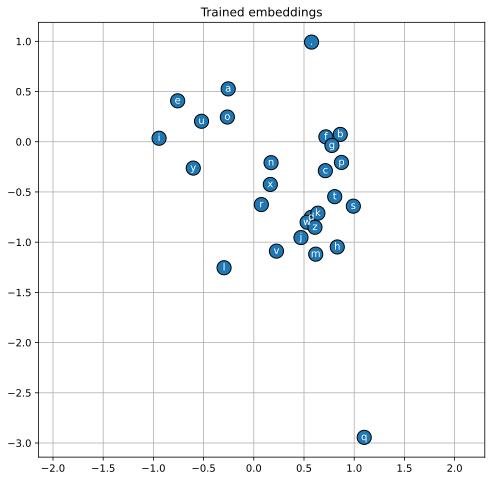

In [18]:
plt.figure(figsize=(8, 8))
plt.scatter(model.C[:, 0].data, model.C[:, 1].data, s=200, edgecolors='black', zorder=3)
for i in range(27):
    plt.text(model.C[i, 0].item(), model.C[i, 1].item(), itos[i], ha="center", va="center", color='white')

plt.grid('minor')
plt.axis('equal')
plt.title("Trained embeddings");

Observe that the vowels are clustered together with `y`. And there are vectors such as `q` and `.` that are isolated from other vectors. We can say that the network has learned these characters. On the other hand, the other consonants being clustered too tightly indicates that the network is not able to understand the subtle differences with these characters, hence just grouping them together.

It seems like it will be difficult improve this with further training or improvements to the network hyparameters. Indeed, we saw that increasing network width, which should have resulted in overfitting the training set, resulted in increasing train and validation losses. In the next section, we will increase the number of dimensions of the embedding space and see whether this improves performance.

### Increasing the embedding dimension

Based on our previous observations, we consider increasing embedding size to 10. Note that we increase the width of the MLP to account for the increase in the number of input neurons.

In [19]:
model = MLP(embedding_size=10, width=200, block_size=3)
hist = trainer.run(model, 200000, verbose=True, lr_find=True, lre_min=-3, lre_max=0.4);

Setting learning rate to 6.94e-02
[000001/200000]      loss=24.1302     loss_val=30.1711
[006251/200000]      loss=2.6777      loss_val=2.7990
[012501/200000]      loss=2.5296      loss_val=2.5788
[018751/200000]      loss=2.3632      loss_val=2.5150
[025001/200000]      loss=2.0811      loss_val=2.4263
[031251/200000]      loss=2.1178      loss_val=2.4216
[037501/200000]      loss=1.9760      loss_val=2.4203
[043751/200000]      loss=2.1387      loss_val=2.3735
[050001/200000]      loss=1.8479      loss_val=2.3623
[056251/200000]      loss=2.2777      loss_val=2.3495
[062501/200000]      loss=2.4247      loss_val=2.3252
[068751/200000]      loss=1.9783      loss_val=2.3348
[075001/200000]      loss=2.3556      loss_val=2.3272
Decreasing learning rate to 6.94e-03
[081251/200000]      loss=1.7478      loss_val=2.3314
[087501/200000]      loss=2.4814      loss_val=2.2425
[093751/200000]      loss=1.8232      loss_val=2.2400
[100001/200000]      loss=1.7717      loss_val=2.2386
[106251/20

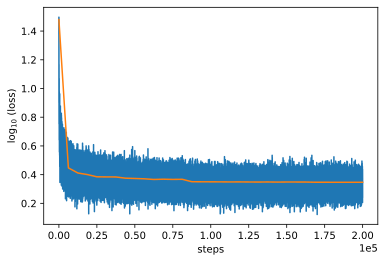

In [20]:
plt.plot(hist['loss_train'].keys(), torch.tensor(list(hist['loss_train'].values())).log10())
plt.plot(hist['loss_valid'].keys(), torch.tensor(list(hist['loss_valid'].values())).log10())

plt.xlabel("steps")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.ylabel("$\log_{10}$ (loss)");

In [21]:
print(f"loss (valid): {trainer.evaluate(model)}")

loss (valid): 2.2227683067321777


## Sampling names

Finally, we look at names generated by the model.

In [22]:
def generate_names(model, block_size, sample_size):
    """Generate names from a Markov process with cond probability table P."""

    names = []
    for _ in range(sample_size):
        out = []
        context = [0] * block_size
        while True:
            p = model(torch.tensor(context)).exp()
            j = torch.multinomial(p, num_samples=1, replacement=True).item()
            if j == 0:
                break
            context = context[1:] + [j]
            out.append(itos[j])
        names.append(''.join(out))
    return names


def name_loss(name, model, block_size):
    nll = 0.0
    context = [0] * block_size
    for c in name + '.':
        p = F.softmax(model(torch.tensor(context))).reshape(-1)[stoi[c]]
        nll += -math.log(p)
        context = context[1:] + [stoi[c]]
    return nll / (len(name) + 1)


sample = generate_names(model, block_size=3, sample_size=12)
name_losses = {n: name_loss(n, model, block_size=3) for n in sample}
for n in sorted(sample, key=lambda n: name_losses[n]):
    print(f"{n:<22} {name_losses[n]:.3f}")

jamelin                1.518
cepha                  1.770
griah                  1.773
zarlyn                 1.791
kaysenna               1.799
ell                    1.865
jadily                 1.940
anvion                 1.946
adabryn                2.014
ginny                  2.079
darly                  2.127
cia                    2.143


Nice! This is a huge improvement from our previous notebook.